loss vs number of layers

In [13]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [14]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


<IPython.core.display.Javascript object>


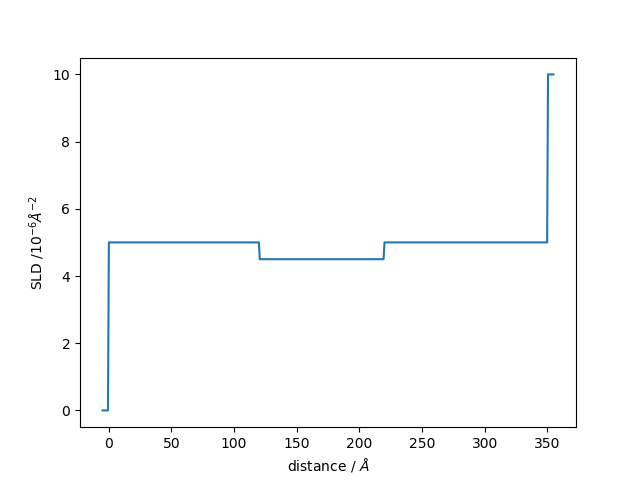

done


In [15]:
%matplotlib notebook
plt.figure(figI)
figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
%%time
from seperat import seperateNLayer as snl
import make_sim_data as msd
datas = []
losses = [0.5,0.75,0.9,1]
lnPosts = []
resolution = 5.
for loss in losses:
    model = ReflectModel(structure, bkg=3e-6, dq=resolution)
    q = np.linspace(0.005, 0.3, 70)
    R = model(q, x_err=resolution)*loss
    sim_dR = msd.main(sim_q=q,sim_R=R)*10
    data = Data1D(data= (q,R,sim_dR))
    for i in range(1,5):
        lnPost = snl(data, i)
        lnPosts.append(lnPost)


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54

[-144232.4505196492, -136629.97948726744, -134728.85635123646, -134578.20899747947, -57000.2096518467, -32910.18625753933, -32436.868747605633, -32357.35481290235, -38930.6486899644, -3985.689439252428, -3990.6557979986624, -3988.679399532851, -44363.752570957986, 1235.90817062648, 1533.510001013522, 1485.8446981208751]


<IPython.core.display.Javascript object>


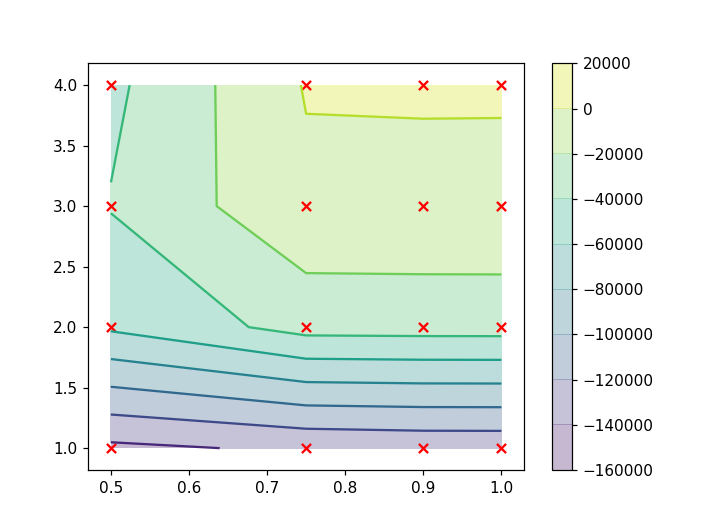

In [9]:
print(lnPosts)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]
zss=[]
for i in range(lenLosses):
    zs=[]
    for j in nLayers:
        z = lnPosts[lenLosses*i+j-1]
        zs.append(z)
    zss.append(zs)
plt.figure(figI)
figI+=1
plt.contour(losses,nLayers,zss)
plt.contourf(losses,nLayers,zss,alpha=0.3)
plt.colorbar()
for x in losses:
    for y in nLayers:
        plt.scatter(x,y,c="red",marker="x")
plt.ylabel("loss")
plt.xlabel("layers")

In [16]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [23]:
from sepObjective import getObjective
import make_sim_data as msd


# resolutions = [1.,3.,7.,9.]
datas = []
# losses = [0.5,0.75,0.9,1]
losses = np.linspace(0.5,1.,5)
lnPosts = []
resolution = 5.
for loss in losses:
    model = ReflectModel(structure, bkg=3e-6, dq=resolution)
    q = np.linspace(0.005, 0.3, 70)
    R = model(q, x_err=resolution)*loss
    sim_dR = msd.main(sim_q=q,sim_R=R)*10
    data = Data1D(data= (q,R,sim_dR))
    for i in range(1,5):
        print("loss:",loss,"n layers:",i)
        objective = getObjective(data=data, nLayers=i,logpExtra=logp_extra)
        fitter = CurveFitter(objective)
        fitter.fit("differential_evolution", target="nlpost")
        lnPost = objective.logpost()
        lnPosts.append(lnPost)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
loss: 0.5 n layers: 1
loss: 0.5 n layers: 2
loss: 0.5 n layers: 3
loss: 0.5 n layers: 4
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.5567

[-11075.273271974418, -10701.844623087964, -10598.865165137533, -10586.748733727574, -6866.279090466205, -6003.615205050414, -5916.486497363521, -5890.512136037603, -3698.407088528064, -2598.690660164139, -2555.2091278056955, -2566.017009968781, -1956.7446297435947, -562.5096860698789, -562.245032617213, -557.1677741230756, -1811.5634629927538, 71.80960602291306, 91.17229594248195, 87.09973192461796]
[[-11075.27327197 -10701.84462309 -10598.86516514 -10586.74873373
   -6866.27909047]
 [ -6003.61520505  -5916.48649736  -5890.51213604  -3698.40708853
   -2598.69066016]
 [ -2555.20912781  -2566.01700997  -1956.74462974   -562.50968607
    -562.24503262]
 [  -557.16777412  -1811.56346299     71.80960602     91.17229594
      87.09973192]] [[-11075.273271974418, -10701.844623087964, -10598.865165137533, -10586.748733727574], [-6866.279090466205, -6003.615205050414, -5916.486497363521, -5890.512136037603], [-3698.407088528064, -2598.690660164139, -2555.2091278056955, -2566.017009968781], [-1

<IPython.core.display.Javascript object>


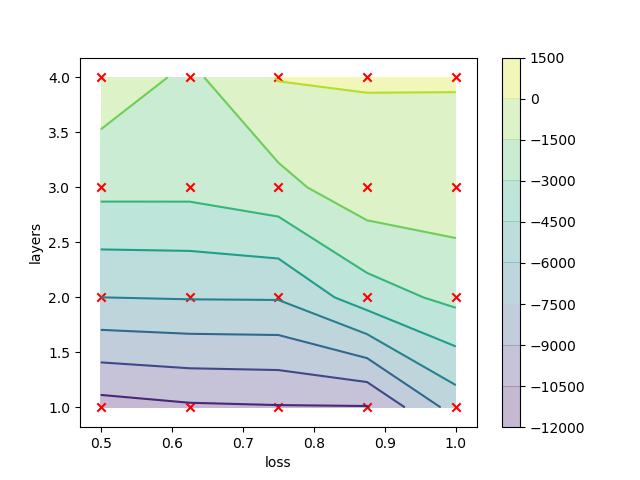

In [26]:
%%time
print(lnPosts)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]

zss=[]
for i in range(lenLosses):
    zs=[]
    for j in nLayers:
        z = lnPosts[len(nLayers)*i+j-1]
        zs.append(z)
    zss.append(zs)
    
z = np.array(lnPosts).reshape((-1,lenLosses))
print(z,zss)

plt.figure(figI);
figI+=1
plt.contour(losses,nLayers,z);
plt.contourf(losses,nLayers,z,alpha=0.3);
plt.colorbar();
for x in losses:
    for y in nLayers:
        plt.scatter(x,y,c="red",marker="x");
plt.ylabel("layers");
plt.xlabel("loss");